# Score LCL dsQTL variants

In this notebook, we score LCL dsQTLs with the trained GM12878 DNase regression model.

In [136]:
# ! pip install git+https://github.com/Genentech/gReLU

In [1]:
import os
import numpy as np
import pandas as pd
import torch

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set experiment parameters

In [3]:
import grelu.lightning
import grelu.resources

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = grelu.resources.load_model(project="GM12878_dnase", model_name='regression', host="https://api.wandb.ai")

wandb: Currently logged in as: suragnair (suragnair-Genentech). Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  


## Variants

In [5]:
# file can be downloaded from https://static-content.springer.com/esm/art%3A10.1038%2Fng.3331/MediaObjects/41588_2015_BFng3331_MOESM26_ESM.xlsx
variants_df = pd.read_csv("/home/nairs51/resources/LCL_dsQTL/41588_2015_BFng3331_MOESM26_ESM.tsv", sep='\t')
variants_df = variants_df[['chrom_hg19', 'pos_hg19', 'allele1', 'allele2', 'label', 'abs_gkm_SVM']]
variants_df = variants_df.set_axis(['chrom', 'pos', 'ref', 'alt', 'label', 'abs_gkm_SVM'], axis=1)
variants_df['label'][variants_df['label']==-1] = 0 
variants_df.head()

/tmp/ipykernel_212073/2148077579.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_df['label'][variants_df['label']==-1] = 0


,chrom,pos,ref,alt,label,abs_gkm_SVM
0,chr1,856583,A,G,1,2.653531
1,chr1,911595,G,A,1,2.821422
2,chr1,1186502,T,A,1,7.167236
3,chr1,1227412,A,G,1,3.957382
4,chr1,1590575,A,G,1,4.785596


In [6]:
from grelu.data.preprocess import filter_blacklist, filter_chromosomes
from grelu.variant import filter_variants

In [7]:
variants = filter_variants(variants_df, max_del_len=0, max_insert_len=0, standard_bases=True)

Initial number of variants: 28309
Final number of variants: 28309


In [8]:
variants = filter_chromosomes(variants, include='autosomesXY')

Keeping 28309 intervals


## Predict

In [9]:
import grelu.variant

odds = grelu.variant.predict_variant_effects(
    variants=variants,
    model=model, 
    devices=0, # Run on GPU 0
    num_workers=8,
    batch_size=128,
    genome="hg19",
    compare_func="subtract", 
    return_ad=True, # Return an anndata object.
    rc = True, # Reverse complement the ref/alt predictions and average them.
)

making dataset


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 885/885 [00:44<00:00, 20.04it/s]


/usr/local/lib/python3.11/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
import sklearn.metrics

In [12]:
auprc = sklearn.metrics.average_precision_score(variants['label'].ravel(), np.abs(odds.X.ravel()))
auprc

0.2998101249840145

In [13]:
pr, rec, _ = sklearn.metrics.precision_recall_curve(variants['label'].ravel(), np.abs(odds.X.ravel()))

### Plot

In [23]:
import matplotlib.pyplot as plt

In [14]:
prsvm, recsvm, _ = sklearn.metrics.precision_recall_curve(variants_df['label'].ravel(), variants_df['abs_gkm_SVM'].ravel())

In [15]:
prrd, recrd, _ = sklearn.metrics.precision_recall_curve(variants_df['label'].ravel(), variants_df['abs_gkm_SVM'].ravel()[np.random.permutation(len(variants_df))])

In [16]:
gkm_auprc = sklearn.metrics.average_precision_score(variants_df['label'].ravel(), variants_df['abs_gkm_SVM'].ravel())

In [17]:
random_auprc = sklearn.metrics.average_precision_score(variants_df['label'].ravel(), variants_df['abs_gkm_SVM'].ravel()[np.random.permutation(len(variants_df))])

In [18]:
# enformer computed scores
enformer_preds = pd.read_csv("/home/nairs51/relu/sequence-function-mask-model/src/notebooks/20240514_Enformer_Borzoi_grelu_dsQTL/enformer_scores_1152bp.tsv", sep='\t')
enformer_preds.head(2)

,chrom_hg19,pos_hg19,allele1,allele2,gkm_SVM,abs_gkm_SVM,label,enformer_task_12_ENCFF093VXI_LFC,enformer_task_69_ENCFF915DFR_LFC
0,chr1,856583,A,G,2.653531,2.653531,1,0.247190,0.212708
1,chr1,911595,G,A,2.821422,2.821422,1,-0.407559,-0.470603


In [19]:
len(enformer_preds) == len(variants_df)

True

In [20]:
enf_auprc = sklearn.metrics.average_precision_score(enformer_preds['label'].ravel(), np.abs(enformer_preds['enformer_task_12_ENCFF093VXI_LFC'].ravel()))

In [21]:
prenf, recenf, _ = sklearn.metrics.precision_recall_curve(enformer_preds['label'].ravel(), np.abs(enformer_preds['enformer_task_12_ENCFF093VXI_LFC'].ravel()))

Text(0.5, 1.0, 'LCL DNase QTL classification')

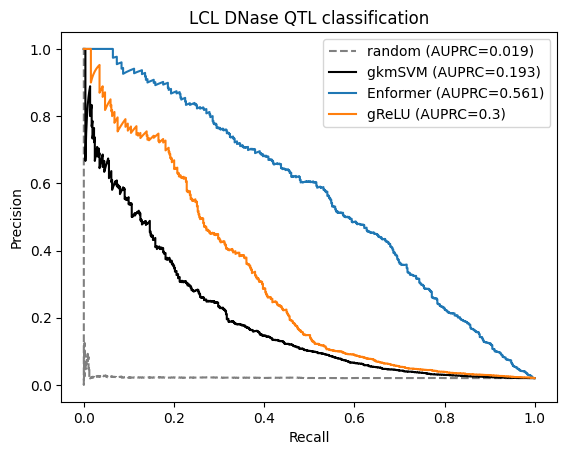

In [24]:
plt.plot(recrd, prrd, label='random (AUPRC={})'.format(round(random_auprc,3)), c='gray', linestyle='--')
plt.plot(recsvm, prsvm, 'k', label='gkmSVM (AUPRC={})'.format(round(gkm_auprc,3)))
plt.plot(recenf, prenf, label='Enformer (AUPRC={})'.format(round(enf_auprc,3)))
plt.plot(rec, pr, label='gReLU (AUPRC={})'.format(round(auprc, 3)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("LCL DNase QTL classification")

# plt.savefig("figures/AUPRC.pdf", dpi=300)

## Examples

In [25]:
from grelu.transforms.prediction_transforms import Aggregate
lcl_score = Aggregate(tasks=[0], model=model)

In [26]:
np.argsort(np.abs(odds.X.ravel()[:573]))[::-1][:50]

array([191,  95, 242, 189,  25, 352, 498,  41, 359, 330, 456, 523, 230,
        65, 170, 304,  67, 283, 379, 263, 302, 194, 376,  14, 226, 521,
       396, 218,  68, 524,   9, 288, 127, 467,  79, 284, 495, 468, 173,
       422, 535, 337,   3, 161, 148, 357, 490, 485, 436, 123])

In [27]:
VARIANT_IDX = 337
variant = odds[VARIANT_IDX, :] 

In [28]:
variants_df.iloc[VARIANT_IDX]

chrom               chr2
pos            216696316
ref                    G
alt                    A
label                  1
abs_gkm_SVM     6.607731
Name: 337, dtype: object

In [29]:
ref_seq, alt_seq = grelu.variant.variant_to_seqs(
    seq_len=model.data_params['train_seq_len'],
    genome='hg19',
    **variant.obs.iloc[0][["chrom", "pos", "ref", "alt"]]
)

In [30]:
SEQLEN = 2114

In [31]:
import grelu.interpret.score

ref_attrs = grelu.interpret.score.get_attributions(
    model, ref_seq, prediction_transform=lcl_score, device=0,
    seed=0, method="inputxgradient",
)

alt_attrs = grelu.interpret.score.get_attributions(
    model, alt_seq, prediction_transform=lcl_score, device=0,
    seed=0, method="inputxgradient",
)

/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


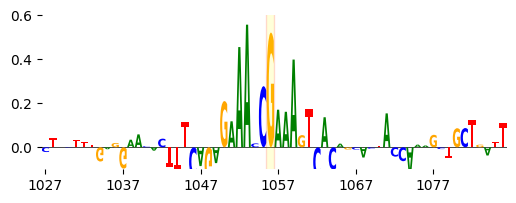

In [32]:
import grelu.visualize
grelu.visualize.plot_attributions(
    ref_attrs, start_pos=SEQLEN//2-30, end_pos=SEQLEN//2+30,
    highlight_positions=[SEQLEN//2-1], ticks=10,
    edgecolor='red', 
    figsize=(6,2),
)
plt.ylim(-0.1,0.6)
plt.savefig("figures/ref.pdf")

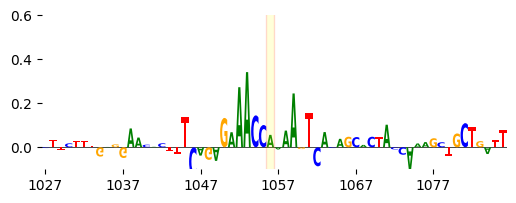

In [33]:
grelu.visualize.plot_attributions(
    alt_attrs, start_pos=SEQLEN//2-30, end_pos=SEQLEN//2+30,
    highlight_positions=[SEQLEN//2-1], ticks=10,
    edgecolor='red',
    figsize=(6,2)
)
plt.ylim(-0.1,0.6)
plt.savefig("figures/alt.pdf")